# KIV/OPIS Oborový projekt IS

Párování (v angl. “matching”) je statistická technika používaná k vyhodnocování efektu léčby porovnáním léčených a neléčených pacientů.
Cílem párovacích metod je nalézt pro každého léčeného pacienta jednoho nebo více neléčených pacientů s podobným stavem oproti kterým lze evaluovat efekty léčby.
Premisou takového postupu je umožnit odhadnout reálné účinky léčby a současně redukovat vzniklý statistický bias.

### Analýza

Jestliže je zkoumaný výsledek binární – léčba (ne)zabrala, je pro analýzu párovaných dat možné použít metodu “podmíněné logistické regrese” (rozšíření klasické logistické regrese), která umožňuje vzít v úvahu data rozdělená do mnoha shluků (tzv. stratifikace), kontinuální a binární způsoby léčení (prediktory) a umožňuje kontrolovat kovariáty.
V určitých případech je možné použít jednodušších metod, jako “paired difference test”, “McNemar's test” a “Cochran-Mantel-Haenszel test”.

Jestliže má být výstup studie kontinuální (výstup zaznamenaný v čase), musí být proveden odhad technikou “průměrného efektu léčby” – “average treatment effect (ATE)”.

Statistické párování lze také použít jako metoda pro předzpracování dat, pro použití další metodou, např. regresními technikami (lineární regrese, polynomiální regrese,…).

### Kovariát (covariate)

Kovariáty jsou charakteristikami účastníků experimentu (jejich vlastnosti, vyjma vlastní léčby).
Jestliže jsou před samotným experimentem nasbírána data o charakteristikách, je možné při studii na účastnících experimentu vyhodnocovat např. jak léčba ovlivňuje různé populační skupiny.
Případně se tato data dají použít pro řízení vlivu jednotlivých kovariátů na studii.

Kovariáty jako takové mají vliv na výstup studie, udejme příklad.
Mějme experiment zkoumající vliv antihypertenziv (léků snižujících krevní tlak) při léčbě posttraumatické stresové poruchy (PTSP) vyskytující se u válečných veteránů.
Míra dávky léku je v tomto kontextu léčbou, zatímco věk a další biologické rysy (váha, výška) jsou faktory ovlivňující výkonnost léčby, jsou tedy kovariáty léčby.

Kovariát může být jak nezávislou proměnnou, tak nechtěnou proměnnou mající přímý vliv na výsledek studie.
Obecně lze říci, že započítáním kovariátů lze dosáhnou vyšší věrohodnosti studie.

### Propensity score matching (PSM)

Párování skóre náchylnosti je raná párovací technika, vytvořená v rámci Rubinova kauzálního modelu.
Technika však vykazuje modelovou závislost – “model dependence” (jednotlivé predikce jsou výrazně odlišné v závislosti na parametrech modelu), vysoký bias, neefektivnost a není tedy dle jistého článku doporučována.

Konkrétně tato technika není doporučována v článku *Why Propensity Scores Should Not Be Used for Matching*.
Autoři v tomto článku vysvětlují, kdy je technika PSM používána a proč je tak používána nesprávně.
Prezentují techniky CEM (Coarsened Exact Matching) a MDM (Mahalanobis Discrepancy Matching), které představují alternativu k PSM dávající v určitých případech smysluplnější výsledky než PSM.
Svoje tvrzení dokazují experimenty.

## Příprava dat

Načteme soubor s daty z klinické studie srdečních nemocí.

In [0]:
import pandas as pd
import time

t = time.time()
df = pd.read_excel('fmpl-sits-dataset.xlsx', sheet_name='all', header=8, index_col=None, na_values=['NA'], usecols='B:C,E:BY')
elapsed = time.time() - t

print('Excel load time: {:.2f} seconds'.format(elapsed))
print('Number of rows: {}'.format(df.shape[0]))

Excel load time: 38.19 seconds
Number of rows: 2890


In [0]:
def fillNaN_with_unifrand(df):
    a = df.values
    m = np.isnan(a) # mask of NaNs
    mu, sigma = df.mean(), df.std()
    a[m] = np.random.normal(mu, sigma, size=m.sum())
    return df

Do proměnných uložím názvy sloupců, se kterými budu pracovat.
Jedná se o názvy sloupců z datasetu, ale i o nové názvy sloupců, které budu teprve vytvářet.

In [0]:
# General
AGE = 'age'
SEX = 'sex'
BMI = 'BMI'
HEIGHT = 'heightvalue'
WEIGHT = 'weight'
NIHSS = 'NIHSS baseline'
NIHSS_DISCHARGE = 'NIHSS-diff-discharge'
TROMBECTOMY = 'thrombectomyDone'
TROMBOLYSIS = 'thrombolysisIV'
TREATMENT = 'treatment'

GEN_LIST = [AGE, SEX, HEIGHT, WEIGHT, NIHSS_DISCHARGE]

# Diagnosis
BOOL_VTA = 'involvedVascularTerritorryArterior'
BOOL_VTL = 'involvedVascularTerritorryLeft'
BOOL_VTP = 'involvedVascularTerritorryPosterior'
BOOL_VTR = 'involvedVascularTerritorryRight'
BOOL_VTU = 'involvedVascularTerritorryUnknown'
BOOL_RFC = 'RiskFactorsCount'
BOOL_RFU = 'RiskFactorsUnknown'
BOOL_AFB = 'atrialFibrilation'
BOOL_CHF = 'congestiveHeartFailure'
BOOL_DIA = 'diabetes'
BOOL_HYL = 'hyperlipidemia'
BOOL_HYT = 'hypertension'
BOOL_SEM = 'previousStrokeEarlierThan3M'
BOOL_SWM = 'previousStrokeWithin3M'
BOOL_PTA = 'previousTIAOrAmaurosis'
BOOL_SC = 'smokerCurrent'
BOOL_SP = 'smokerPrevious'
BOOL_VD = 'vascularDisease'

DIAG_LIST = [
    BOOL_VTA, BOOL_VTL, BOOL_VTP, BOOL_VTR, #BOOL_VTU,
    BOOL_RFC, BOOL_RFU, BOOL_AFB, BOOL_CHF, BOOL_DIA,
    BOOL_HYL, BOOL_HYT, BOOL_SEM, BOOL_SWM, BOOL_PTA,
    BOOL_SC, BOOL_SP, BOOL_VD
    ]

# Treatment
TREA_AAO = 'anticoagulantsOral'
TREA_ADO = 'antidiabeticOral'
TREA_AHI = 'antihypertensiveIV'
TREA_AHP = 'antihypertensivePO'
TREA_APO = 'antiplateletOther'
TREA_ASP = 'aspirin'
TREA_CLG = 'clopidogrel'
TREA_DIP = 'dipyridamole'
TREA_HPC = 'heparinLMWHPreventionCMP'
TREA_HPT = 'heparinLMWHPreventionTromb'
TREA_HPR = 'heparinPreventionCMP'
TREA_HPB = 'heparinPreventionTromb'
TREA_INS = 'insulin'
TREA_NSA = 'nsaid'

TREA_LIST = [
    TREA_AAO, TREA_ADO, TREA_AHI, TREA_AHP, TREA_APO,
    TREA_ASP, TREA_CLG, TREA_DIP, TREA_HPC, TREA_HPT,
    TREA_HPR, TREA_HPB, TREA_INS, TREA_NSA
]

In [0]:
df.sex = df.sex.replace('M', 1)
df.sex = df.sex.replace('F', 0)

# Fill NaN values for treatment columns (supposedly no treatment provided)
df[TROMBECTOMY] = df[TROMBECTOMY].fillna(0)
df[TROMBOLYSIS] = df[TROMBOLYSIS].fillna(0)

In [0]:
# Initialize Treatment Groups
trombectomyGroup = df.loc[(df[TROMBECTOMY] == True) & (df[TROMBOLYSIS] == False)]
print('Trombectomy rows: {}'.format(trombectomyGroup.shape[0]))

trombolysisGroup = df.loc[(df[TROMBECTOMY] == False) & (df[TROMBOLYSIS] == True)]
print('Trombolysis rows: {}'.format(trombolysisGroup.shape[0]))

bridgeGroup = df.loc[(df[TROMBECTOMY] == True) & (df[TROMBOLYSIS] == True)]
print('Bridge rows: {}'.format(bridgeGroup.shape[0]))

noTreatmentGroup = df.loc[(df[TROMBECTOMY] == False) & (df[TROMBOLYSIS] == False)]
print('No treatment rows: {}'.format(noTreatmentGroup.shape[0]))

Trombectomy rows: 66
Trombolysis rows: 1251
Bridge rows: 261
No treatment rows: 1312


In [0]:
import numpy as np

# Merge Data Frames back into 'df' variable
# df = pd.concat([trombectomyGroup, trombolysisGroup, bridgeGroup, noTreatmentGroup])
df = pd.concat([trombolysisGroup, trombectomyGroup, bridgeGroup, noTreatmentGroup])

# df['bridge'] = np.where(df.thrombectomyDone == 1 & df.thrombolysisIV == 1, 1, 0)

new_df = df.filter(GEN_LIST + DIAG_LIST, axis=1)

new_df[NIHSS_DISCHARGE] = df[NIHSS_DISCHARGE].fillna(0)
# new_df[NIHSS_DISCHARGE] = new_df[NIHSS] + new_df[NIHSS_DISCHARGE]

# Initialize TREATMENT column
new_df[TREATMENT] = np.where(df[TROMBOLYSIS] == 1, 1, 0)
new_df[TREATMENT] = np.where(df[TROMBECTOMY] == 1, 1, 0)

print('Number of rows: {}'.format(new_df.shape[0]))

new_df[HEIGHT] = fillNaN_with_unifrand(new_df[HEIGHT])

test = new_df[new_df.treatment == 1]
control = new_df[new_df.treatment == 0]

Number of rows: 2890


## Analýza dat

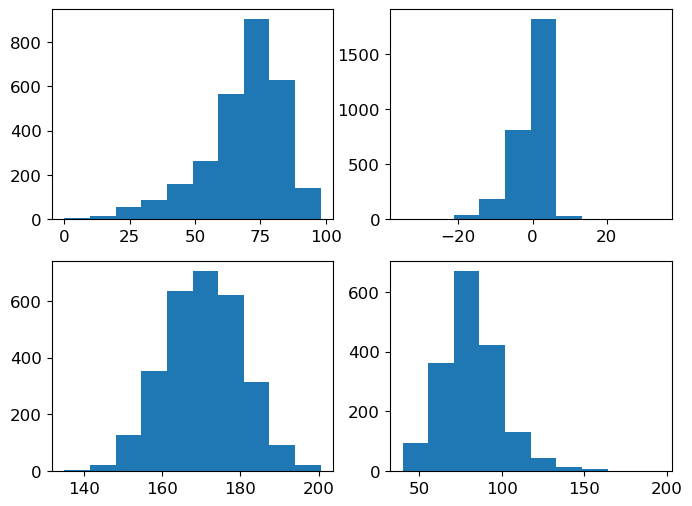

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(new_df[AGE])  # df.hist(AGE)
axs[0, 1].hist(new_df[NIHSS_DISCHARGE])
axs[1, 0].hist(new_df[HEIGHT])
axs[1, 1].hist(new_df[WEIGHT])

In [0]:
# 0 - control, 1 - treatment
new_df.groupby(TREATMENT)[NIHSS_DISCHARGE].mean()

treatment
0   -1.282091
1   -3.648318
Name: NIHSS-diff-discharge, dtype: float64

In [0]:
# Are the treated different in terms of age and sex?
new_df.groupby(TREATMENT)[['age', 'sex']].mean()

,age,sex
treatment,,
0,68.626303,0.530473
1,68.330275,0.553517


## Propensity Score Matching

### Provedení léčebných postupů vede ke snížení NIHSS sledovaných pacientů

Trombectomie, Trombolýza

H0: Provedení léčebných postupů NEVEDE ke snížení NIHSS sledovaných pacientů

HA: Provedení léčebných postupů VEDE ke snížení NIHSS sledovaných pacientů

In [0]:
new_df

,age,sex,heightvalue,weight,NIHSS-diff-discharge,involvedVascularTerritorryArterior,involvedVascularTerritorryLeft,involvedVascularTerritorryPosterior,involvedVascularTerritorryRight,RiskFactorsCount,RiskFactorsUnknown,atrialFibrilation,congestiveHeartFailure,diabetes,hyperlipidemia,hypertension,previousStrokeEarlierThan3M,previousStrokeWithin3M,previousTIAOrAmaurosis,smokerCurrent,smokerPrevious,vascularDisease,treatment
1,57.0,0.0,185.756851,89.0,-4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,72.0,1.0,156.409169,77.0,-6.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,86.0,0.0,170.435391,55.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,63.0,0.0,157.010455,70.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,40.0,1.0,161.263228,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2885,37.0,1.0,175.387395,NaN,0.0,0.0,0.0,0.0,0.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2886,79.0,0.0,177.144846,NaN,0.0,0.0,0.0,0.0,0.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2887,73.0,1.0,162.341922,NaN,0.0,0.0,0.0,0.0,0.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2888,31.0,0.0,155.711061,NaN,0.0,0.0,0.0,0.0,0.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Vzhledem ke všem přítomným kovariátům a sloupci *léčba* (TREATMENT), který indikuje, zda je subjekt léčený nebo kontrolní, bychom si přáli, mít kvatitativní způsob jak změřit, jestli jsou kovariáty mezi těmito dvěma skupinami vyvážené.

Abychom tento rovznovážný stav posoudili, podívejme se na standardizované odchylky od průměru (standardized mean difference).

$$ smd = \frac{\bar{X}_t - \bar{X}_c}{\sqrt{(s^2_t + s^2_c) / 2}} $$

* $ \bar{X}_t, \bar{X}_c $ označuje střední hodnotu pro léčenou a kontrolní skupinu.
* $ s^2_t, s^2_c $ označuje směrodatné odchyly

Spočítáme SMD pro každý příznak. Pro určení, jestli je příznak vyvážený, nebo ne se použije násedující pravidlo:

* SMD < 0.1 Ideální stav, hodnoty SMD pro randomizovanou studii by sem měly patřit.
* SMD in (0.1-0.2) Hraniční stav, příznaky nejsou nutně nebalancované, budu je tedy v našem případě považovat za balancované.
* SMD > 0.2 Vázně nebalancované

In [0]:
features = new_df.columns.tolist()
features.remove(TREATMENT)
features.remove(NIHSS_DISCHARGE)

agg_operations = {TREATMENT: 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})

table_one = new_df.groupby(TREATMENT).agg(agg_operations)

In [0]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})

In [0]:
table_one_smd = compute_table_one_smd(table_one)
table_one_smd

,features,smd
0,age,0.0213
1,sex,0.0462
2,heightvalue,0.1415
3,weight,0.3387
4,involvedVascularTerritorryArterior,0.6968
5,involvedVascularTerritorryLeft,0.2758
6,involvedVascularTerritorryPosterior,0.0709
7,involvedVascularTerritorryRight,0.4154
8,RiskFactorsCount,0.3208
9,RiskFactorsUnknown,0.7136


In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = [AGE, HEIGHT, WEIGHT]

# treatment will be our label for estimating the propensity score,
# and death is the outcome that we care about, thus is also removed
# from the step that is estimating the propensity score
death = new_df[NIHSS_DISCHARGE]
treatment = new_df[TREATMENT]
df_cleaned = new_df.drop([NIHSS_DISCHARGE, TREATMENT], axis=1)

# df_cleaned.replace(np.nan, 0)

column_transformer = ColumnTransformer(
    [('numerical', StandardScaler(), num_cols)],
    sparse_threshold=0,
    remainder='passthrough'
)
data = column_transformer.fit_transform(df_cleaned)
data.shape

(2890, 21)

In [0]:
data[np.isnan(data)] = 0
data

array([[-0.74804347,  1.55310841,  0.36471539, ...,  0.        ,  0.        ,  0.        ],
       [ 0.21992263, -1.44385157, -0.31458402, ...,  0.        ,  1.        ,  0.        ],
       [ 1.12335766, -0.01150589, -1.55996628, ...,  0.        ,  0.        ,  0.        ],
       ...,
       [ 0.2844537 , -0.83800392,  0.        , ...,  0.        ,  0.        ,  0.        ],
       [-2.42585137, -1.51514172,  0.        , ...,  0.        ,  0.        ,  0.        ],
       [ 0.86523336, -0.47514809,  0.        , ...,  0.        ,  0.        ,  0.        ]])

In [0]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver='liblinear')
logistic.fit(data, treatment)

LogisticRegression(solver='liblinear')

In [0]:
pscore = logistic.predict_proba(data)[:, 1]
pscore

array([0.29574548, 0.12197148, 0.13486686, ..., 0.00740921, 0.01709091, 0.00695085])

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(treatment, pscore)

0.7661934540109128

In [0]:
mask = treatment == 1

pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (327,)
control count: (2563,)


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


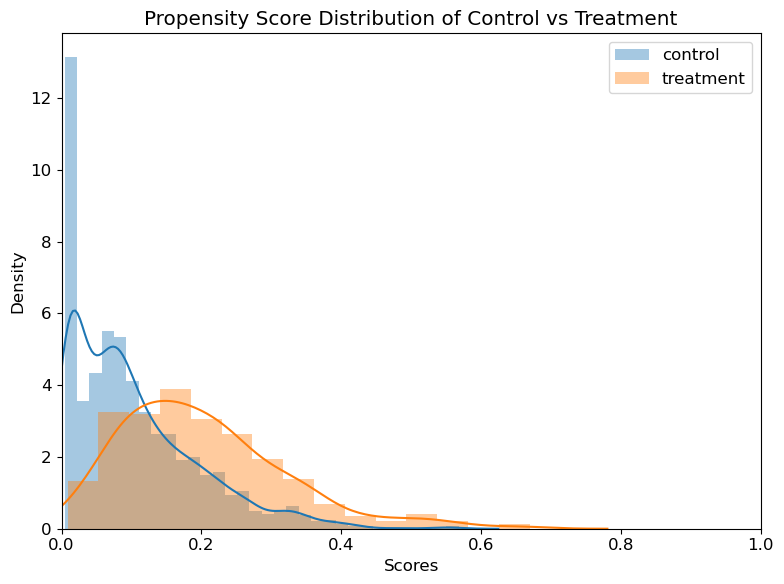

In [0]:
import seaborn as sns

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

ax = sns.distplot(neg_pscore, label='control')
ax = sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [0]:
from sklearn.neighbors import NearestNeighbors

def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices

In [0]:
sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
# sim_indices

In [0]:
_, counts = np.unique(sim_indices[:, 0], return_counts=True)
np.bincount(counts)

array([  0, 213,  36,   7,   4,   1])

In [0]:
df_cleaned[TREATMENT] = treatment
df_cleaned[NIHSS_DISCHARGE] = death
df_pos = df_cleaned[mask]
df_neg = df_cleaned[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

,age,sex,heightvalue,weight,involvedVascularTerritorryArterior,involvedVascularTerritorryLeft,involvedVascularTerritorryPosterior,involvedVascularTerritorryRight,RiskFactorsCount,RiskFactorsUnknown,atrialFibrilation,congestiveHeartFailure,diabetes,hyperlipidemia,hypertension,previousStrokeEarlierThan3M,previousStrokeWithin3M,previousTIAOrAmaurosis,smokerCurrent,smokerPrevious,vascularDisease,treatment,NIHSS-diff-discharge
33,77.0,0.0,170.000000,90.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
49,53.0,1.0,180.000000,100.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0
110,88.0,1.0,153.060849,90.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
127,49.0,1.0,173.064480,NaN,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,-10.0
143,84.0,0.0,170.626045,NaN,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,-6.0


In [0]:
table_one_matched = df_matched.groupby(TREATMENT).agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched)
table_one_smd_matched

,features,smd
0,age,0.0484
1,sex,0.1009
2,heightvalue,0.0668
3,weight,0.0027
4,involvedVascularTerritorryArterior,0.0064
5,involvedVascularTerritorryLeft,0.0477
6,involvedVascularTerritorryPosterior,0.0270
7,involvedVascularTerritorryRight,0.0429
8,RiskFactorsCount,0.0411
9,RiskFactorsUnknown,0.0503


In [0]:
df_pos[NIHSS_DISCHARGE].mean()

-3.6483180428134556

In [0]:
df_neg[NIHSS_DISCHARGE].mean()

-2.3363914373088686

In [0]:
from scipy.stats import stats

num_matched_pairs = df_neg.shape[0]
print('number of matched pairs: ', num_matched_pairs)

# pair t-test
stats.ttest_rel(df_pos[NIHSS_DISCHARGE].values, df_neg[NIHSS_DISCHARGE].values)

number of matched pairs:  327


Ttest_relResult(statistic=-3.04132727969905, pvalue=0.002546422157088463)

### Hypotéza: pacienti ve věku do 65 let 

In [0]:
import numpy as np

# Merge Data Frames back into 'df' variable
# df = pd.concat([trombectomyGroup, trombolysisGroup, bridgeGroup, noTreatmentGroup])
df = pd.concat([trombolysisGroup, trombectomyGroup, bridgeGroup])

# df['bridge'] = np.where(df.thrombectomyDone == 1 & df.thrombolysisIV == 1, 1, 0)

new_df = df.filter(GEN_LIST + DIAG_LIST, axis=1)

new_df[NIHSS_DISCHARGE] = df[NIHSS_DISCHARGE].fillna(0)
# new_df[NIHSS_DISCHARGE] = new_df[NIHSS] + new_df[NIHSS_DISCHARGE]

print('Number of rows: {}'.format(new_df.shape[0]))

new_df[HEIGHT] = fillNaN_with_unifrand(new_df[HEIGHT])

new_df[TREATMENT] = np.where(new_df.age >= 65, 1, 0)

Number of rows: 1578


In [0]:
features = new_df.columns.tolist()
features.remove(AGE)
features.remove(TREATMENT)
features.remove(NIHSS_DISCHARGE)

agg_operations = {TREATMENT: 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})

table_one = new_df.groupby(TREATMENT).agg(agg_operations)

In [0]:
table_one_smd = compute_table_one_smd(table_one)
table_one_smd

,features,smd
0,sex,0.2780
1,heightvalue,0.1275
2,weight,0.4668
3,involvedVascularTerritorryArterior,0.1660
4,involvedVascularTerritorryLeft,0.0572
5,involvedVascularTerritorryPosterior,0.1935
6,involvedVascularTerritorryRight,0.0864
7,RiskFactorsCount,0.6485
8,RiskFactorsUnknown,0.0443
9,atrialFibrilation,0.5784


In [0]:
num_cols = [HEIGHT, WEIGHT]

# treatment will be our label for estimating the propensity score,
# and death is the outcome that we care about, thus is also removed
# from the step that is estimating the propensity score
death = new_df[NIHSS_DISCHARGE]
treatment = new_df[TREATMENT]
df_cleaned = new_df.drop([NIHSS_DISCHARGE, TREATMENT], axis=1)

# df_cleaned.replace(np.nan, 0)

column_transformer = ColumnTransformer(
    [('numerical', StandardScaler(), num_cols)],
    sparse_threshold=0,
    remainder='passthrough'
)
data = column_transformer.fit_transform(df_cleaned)
data.shape

(1578, 21)

In [0]:
data[np.isnan(data)] = 0
data

array([[ 0.41665342,  0.37437856, 57.        , ...,  0.        ,  0.        ,  0.        ],
       [-1.63975571, -0.30788358, 72.        , ...,  0.        ,  1.        ,  0.        ],
       [ 0.2089962 , -1.5586975 , 86.        , ...,  0.        ,  0.        ,  0.        ],
       ...,
       [-1.06036807,  1.11349588, 73.        , ...,  0.        ,  0.        ,  0.        ],
       [-0.23608106, -0.2510284 , 49.        , ...,  0.        ,  0.        ,  0.        ],
       [-0.25763101,  0.        , 69.        , ...,  0.        ,  0.        ,  0.        ]])

In [0]:
logistic = LogisticRegression(solver='liblinear')
logistic.fit(data, treatment)

LogisticRegression(solver='liblinear')

In [0]:
pscore = logistic.predict_proba(data)[:, 1]
pscore

array([0.31061084, 0.90041247, 0.99805784, ..., 0.94727062, 0.11326868, 0.84048766])

In [0]:
roc_auc_score(treatment, pscore)

0.9951883824473934

In [0]:
mask = treatment == 1

pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (1193,)
control count: (385,)


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


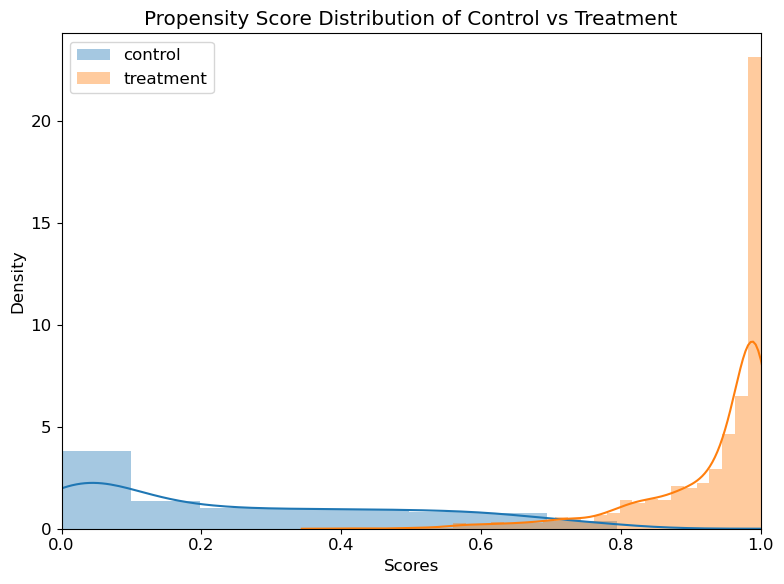

In [0]:
import seaborn as sns

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

ax = sns.distplot(neg_pscore, label='control')
ax = sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [0]:
sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
# sim_indices

In [0]:
_, counts = np.unique(sim_indices[:, 0], return_counts=True)
np.bincount(counts)

array([ 0, 18,  9, ...,  0,  0,  1])

In [0]:
df_cleaned[TREATMENT] = treatment
df_cleaned[NIHSS_DISCHARGE] = death
df_pos = df_cleaned[mask]
df_neg = df_cleaned[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

,age,sex,heightvalue,weight,involvedVascularTerritorryArterior,involvedVascularTerritorryLeft,involvedVascularTerritorryPosterior,involvedVascularTerritorryRight,RiskFactorsCount,RiskFactorsUnknown,atrialFibrilation,congestiveHeartFailure,diabetes,hyperlipidemia,hypertension,previousStrokeEarlierThan3M,previousStrokeWithin3M,previousTIAOrAmaurosis,smokerCurrent,smokerPrevious,vascularDisease,treatment,NIHSS-diff-discharge
2,72.0,1.0,154.784634,77.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,-6.0
3,86.0,0.0,172.536885,55.0,1.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
15,82.0,1.0,166.685779,80.0,0.0,1.0,1.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1,-12.0
17,69.0,0.0,166.798749,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1,0.0
18,84.0,1.0,165.473748,82.0,0.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,-6.0


In [0]:
table_one_matched = df_matched.groupby(TREATMENT).agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched)
table_one_smd_matched

,features,smd
0,sex,1.2118
1,heightvalue,0.9827
2,weight,0.6316
3,involvedVascularTerritorryArterior,1.6145
4,involvedVascularTerritorryLeft,1.0321
5,involvedVascularTerritorryPosterior,0.4017
6,involvedVascularTerritorryRight,0.8617
7,RiskFactorsCount,0.0433
8,RiskFactorsUnknown,0.2679
9,atrialFibrilation,0.9710


In [0]:
df_pos[NIHSS_DISCHARGE].mean()

-2.461860854987427

In [0]:
df_neg[NIHSS_DISCHARGE].mean()

-6.471919530595138

In [0]:
num_matched_pairs = df_neg.shape[0]
print('number of matched pairs: ', num_matched_pairs)

# pair t-test
stats.ttest_rel(df_pos[NIHSS_DISCHARGE].values, df_neg[NIHSS_DISCHARGE].values)

number of matched pairs:  1193


Ttest_relResult(statistic=25.702264758505173, pvalue=2.810995203706411e-116)